In [1]:

import codecs
import json
import configparser
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from dotenv import load_dotenv
from num2words import num2words
from sklearn import linear_model

%matplotlib inline

import dask.array as da
import dask.dataframe as dd
import h5py

import spacy
import lemminflect
sp = spacy.load("en")
sp.Defaults.stop_words.add("left")
sp.Defaults.stop_words.add("right")
sp.Defaults.stop_words.add("near")
sp.Defaults.stop_words.add("far")
sp.Defaults.stop_words.add("middle")
sp.Defaults.stop_words.add("center")
sp.Defaults.stop_words.add("furthest")
sp.Defaults.stop_words.add("first")
sp.Defaults.stop_words.add("second")
sp.Defaults.stop_words.add("third")
sp.Defaults.stop_words.add("fourth")
sp.Defaults.stop_words.add("fifth")
sp.Defaults.stop_words.add("front")
sp.Defaults.stop_words.add("back")
sp.Defaults.stop_words.add("leftmost")
sp.Defaults.stop_words.add("rightmost")
sp.Defaults.stop_words.add("upper")
sp.Defaults.stop_words.add("lower")
sp.Defaults.stop_words.add("nearest")
sp.Defaults.stop_words.add("closest")
sp.Defaults.stop_words.add("uppermost")
sp.Defaults.stop_words.add("lowermost")
sp.Defaults.stop_words.add("highest")
sp.Defaults.stop_words.add("lowest")
sp.Defaults.stop_words.add("closer")
sp.Defaults.stop_words.add("nearer")
sp.Defaults.stop_words.add("farther")
sp.Defaults.stop_words.add("further")
sp.Defaults.stop_words.add("farthest")


import random
random.seed(42)

from time import localtime, strftime

from sklearn.utils import shuffle

from bet_utils.semparse import prob_at_least

In [2]:
ID_FEATS = 3

In [3]:
# Load up config file (needs path; adapt env var if necessary); local imports
load_dotenv()

# load config file, set up paths, make project-specific imports
config_path = os.getenv('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = configparser.ConfigParser()
with codecs.open(config_path, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')

sys.path.insert(0,dsgv_home + "/Utils")
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b, get_image_part
sys.path.insert(0,dsgv_home + "/WACs/WAC_Utils")
from wac_utils import create_word2den, is_relational, filter_refdf_by_filelist, filter_relational_expr
from wac_utils import filter_X_by_filelist, make_mask_matrix, make_X_id_index, train_this_word
from wac_utils import get_X_for_word

from data_utils import load_dfs

from apply_utils import apply_wac_set_matrix, logreg

#sys.path.append(dsgv_home + '/Preproc')

In [4]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = ['refcoco_refdf', 'refcocoplus_refdf']
df = load_dfs(preproc_path, df_names)

In [5]:
with open(preproc_path + '/refcoco_splits.json', 'r') as f:
    rc_splits = json.load(f)

## RefCoco

In [6]:
# mscoco_bbdf_pattern = '/Volumes/BigData_SSD/Data/Computed/ExtractOut/vgg/mscoco_bbdf_vgg19-fc2/mscoco_bbdf_vgg19-fc2_%d.hdf5'
# model_path_prefix = '../TrainWACs/ModelsOut/01_refcoco_vgg'
mscoco_bbdf_pattern = '../../data/Models/ForBToma/mscoco_bbdf_rsn50-max/mscoco_bbdf_rsn50-max_%d.hdf5'
model_path_prefix = '../../data/Models/ForBToma/01_refcoco_rsn'

### Load Image Features

In [7]:
das = []
fhs = []
for n in range(1,8):
    f = h5py.File(mscoco_bbdf_pattern % (n), 'r')
    fhs.append(f)
    das.append(da.from_array(f['img_feats'], chunks=(1000, 4106)))

In [8]:
X = da.concatenate(das)

In [9]:
X.shape

(602408, 2058)

In [10]:
rc_all_test = rc_splits['testA'] + rc_splits['testB'] # rc_splits['val']  # rc_splits['testA'] + rc_splits['testB']
X_ts = filter_X_by_filelist(X, rc_all_test)
refdf_test = filter_refdf_by_filelist(df['refcoco_refdf'], rc_all_test)

In [11]:
# this is small enough to be fully in memory
X_ts = X_ts[:].compute()

In [12]:
# Meaning that I can already close the file handles
for fh in fhs:
    fh.close()

In [13]:
word2den_ts = create_word2den(refdf_test)
X_idx_ts = make_X_id_index(X_ts)
mask_matrix_ts = make_mask_matrix(X_ts, X_idx_ts, word2den_ts, word2den_ts.keys())

### Load WACs

In [14]:
def exp2indseq(w2i, exp):
    return [word2ind[w] for w in exp.split() if w in word2ind] #the list of indices for each "word" in exp

In [15]:
def imageid2rows(idx, ic, ii):
    '''return all regions that belong to an image, as indices into X (via idx)'''
    # or should this be a separate dictionary?
    return [v for k,v in idx.items() if k[0] == ic and k[1] == ii]

In [16]:
with h5py.File(model_path_prefix + '.hdf5', 'r') as f:
    wacs = f['wac_weights'][:]   # slice, to actually read into memory (as ndarray)

In [17]:
with codecs.open(model_path_prefix + '.json', 'r') as f:
    modelpars, wordlist = json.load(f)

In [18]:
refdf_test.head()

,i_corpus,image_id,region_id,r_corpus,rex_id,refexp,tagged
0,1,581563,1345868,refcoco,71,lower left corner darkness,"[[lower, JJR], [left, VBD], [corner, JJR], [da..."
1,1,581563,1345868,refcoco,72,bpttom left dark,"[[bpttom, NN], [left, VBD], [dark, NN]]"
2,1,581563,1345868,refcoco,73,black van in front of cab,"[[black, JJ], [van, NN], [in, IN], [front, NN]..."
3,1,581563,344837,refcoco,74,taxi,"[[taxi, NN]]"
4,1,581563,344837,refcoco,75,the taxi cab bottom right,"[[the, DT], [taxi, NN], [cab, NN], [bottom, NN..."


### Apply all WACs to all regions

In [19]:
all_applied = apply_wac_set_matrix(X_ts[:, ID_FEATS:], wacs.T, net=logreg) #applies all wac and returns a matrix of results, rows are entities and columns are words

In [20]:
word2ind = {w[0]:n for n,w in enumerate(wordlist)} #creates dictionary from word to its index in the wordlist

In [21]:
#dependency parse each refexp to make generation a bit easier hopefully
refdf_test["DepParse"] = refdf_test.apply(lambda row: sp(row.refexp), axis=1)

In [22]:
#this function will go through and create some sort of representation of every referring expression (and hopefully also every word?) per picture
ref_dict = {}
for i in refdf_test["image_id"].unique():
    ref_dict[i] = {refdf_test["refexp"][j] : j for j in refdf_test[refdf_test["image_id"] == i].index}
ref_vocab = defaultdict(set)
for k, v in ref_dict.items():
    for exp in v:
        for word in refdf_test.loc[v[exp]]["DepParse"]:
            if word.text in word2ind and not word.is_stop:
                ref_vocab[k].add(word.text)

In [23]:
singularity_exceptions = {"sprinkles", "stripes", "jeans", "pants", "shorts", "glasses", "spots", "clothes"}

def get_good_nps(image_id):
    nps = set()
    for k, v in ref_dict[image_id].items():
        for chunk in refdf_test.loc[v]["DepParse"].noun_chunks:
            if all([token.text in word2ind for token in chunk]) and not chunk.root.is_stop:
                nps.add(" ".join([token._.inflect("NN") if (token == chunk.root and token.text not in singularity_exceptions) else token.text for token in chunk if not token.is_stop]))
    return nps

In [24]:
image_ids = list(refdf_test.image_id.unique())
ref_dict_per_id = [ref_dict[x] for x in image_ids]
ref_voc_per_id = [ref_vocab[x] for x in image_ids]
good_nps_per_id = [get_good_nps(x) for x in image_ids]
im_ref_df = pd.DataFrame({"image_id": image_ids, "ref_exps": ref_dict_per_id, "vocab": ref_voc_per_id, "NPs": good_nps_per_id}).set_index("image_id")


In [25]:
im_ref_df.head()

,ref_exps,vocab,NPs
image_id,,,
581563,"{'lower left corner darkness': 0, 'bpttom left...","{van, black, corner, dark}",{black van}
581518,"{'top donut': 8, 'top of donuts': 7, 'donut wc...","{donut, sprinkles}","{donut, sprinkles}"
581346,"{'left zebra butt': 13, 'zebra on the left': 1...","{zebra, butt}","{zebra, zebra butt}"
581282,"{'person bottom left': 18, 'left black shirt':...","{shirt, black, person}",{black shirt}
580668,"{'man on right': 20, 'right man': 21, 'man sit...","{person, bench, man, blue, white, yellow, sitt...","{person, bench, man, white car, car, blue car}"


In [26]:
all_nps = set().union(*good_nps_per_id)

In [27]:
def generate_true_exp(rfdf, idx: """image id""", n: """maximum number of statements per image"""):
    #this function will generate true sentences containing refexp for a given image
    truths = []
    eligible_NPs = list(rfdf.loc[idx]["NPs"])
    random.shuffle(eligible_NPs)
    while len(truths) < n:
        if not eligible_NPs:
            break
        np = eligible_NPs.pop()
        if set(np.split()).intersection(singularity_exceptions):
            article = ""
            verb = "are"
        elif np.startswith(('a','e','i','o','u')):
            article = "an "
            verb = "is"
        else:
            article = "a "
            verb = "is"
        truths.append(f"There {verb} {article}{np}.")
    return truths


def generate_false_exp(rfdf, every_np, idx: """image id""", n: """number of statements per image"""):
    #this function will generate false sentences (hopefully) for a given image
    lies = []
    eligible_NPs = list(every_np)
    random.shuffle(eligible_NPs)
    for np in eligible_NPs:
        if len(lies) >= n:
            break
        elif any([word in rfdf.loc[idx]["vocab"] for word in np.split()]):
            continue
        else:
            if np.startswith(('a','e','i','o','u')):
                article = "an"
            else:
                article = "a"
            lies.append(f"There is {article} {np}.")
    return lies

In [28]:
pos = [generate_true_exp(im_ref_df, x, 2) for x in im_ref_df.index.to_series()]
neg = [generate_false_exp(im_ref_df, all_nps, x, 2) for x in im_ref_df.index.to_series()]
im_ref_df["Positives"] = pos
im_ref_df["Negatives"] = neg

In [29]:
im_ref_df.head()

,ref_exps,vocab,NPs,Positives,Negatives
image_id,,,,,
581563,"{'lower left corner darkness': 0, 'bpttom left...","{van, black, corner, dark}",{black van},[There is a black van.],"[There is a pie., There is a striped clothes.]"
581518,"{'top donut': 8, 'top of donuts': 7, 'donut wc...","{donut, sprinkles}","{donut, sprinkles}","[There is a donut., There are sprinkles.]","[There is a woman person., There is a pot pie.]"
581346,"{'left zebra butt': 13, 'zebra on the left': 1...","{zebra, butt}","{zebra, zebra butt}","[There is a zebra., There is a zebra butt.]","[There is a yellow hat., There is a girl.]"
581282,"{'person bottom left': 18, 'left black shirt':...","{shirt, black, person}",{black shirt},[There is a black shirt.],"[There is a screen thing., There is a pizza ha..."
580668,"{'man on right': 20, 'right man': 21, 'man sit...","{person, bench, man, blue, white, yellow, sitt...","{person, bench, man, white car, car, blue car}","[There is a blue car., There is a man.]","[There is a touching food., There is a partial..."


In [30]:
bbs_in_image = refdf_test.groupby("image_id").apply(lambda x: x["region_id"].unique())

In [31]:
numbers = {num2words(n): n for n in range(0, 20)}

def get_np_and_number(sentence: str):
    n = 1
    sent_parsed = sp(sentence)
    try:
        head = [word for word in sent_parsed if word.dep_ == "attr"][0]
    except IndexError:
        return None
    dependents = [word for word in sent_parsed if word.head == head]
    determiner = [word for word in dependents if word.dep_ == "det"]
    if determiner:
        det = determiner[0]
        if det in numbers:
            n = numbers[det]
        refexp = " ".join([x.text for x in sent_parsed if x == head or x in dependents and x != det])
    else:
        refexp = " ".join([x.text for x in sent_parsed if x == head or x in dependents])
    return refexp, n

In [32]:
def eval_sent(w2i, all_applied, all_regs, sent, mode:"""str""" = "fuzzy", threshold:float = None):
    parsed = get_np_and_number(sent) #<- this turns a "There are..." sentence into the relevant refexp, plus the number of entities quantified
    if parsed:
        refexp, n = parsed
    else:
        return "PARSE_FAIL"
    this_exp_seq = exp2indseq(w2i, refexp) #<- this gets the row numbers for each word in the refexp
    if not this_exp_seq:
        return "PARSE_FAIL"
    classifications = [all_applied[all_regs][:, i] for i in this_exp_seq] #<- this is the part that actually runs the classifier
    #classical combination
    if mode == "classical":
        if not threshold:
            raise ValueError("Classical parsing requires a numerical threshold")
        bool_classes = [[ent >= threshold for ent in bb] for bb in classifications]
        boolean_output_vals = []
        if len(bool_classes) > 1:
            for i in range(len(bool_classes[0])):
                boolean_output_vals.append(all([x[i] for x in classifications]))
        return sum(boolean_output_vals) >= n
    #fuzzy combination
    elif mode in {"fuzzy","mixed"}:
        if len(classifications) > 1:
            all_regs_applied = np.multiply.reduce(classifications, axis=0)  #<- multiplies(?) the results
        else:
            try:
                all_regs_applied = classifications[0]
            except IndexError:
                print(sent, this_exp_seq, classifications, this_exp_seq, refexp, n)
                raise IndexError("wtf")
        likelihood = prob_at_least(all_regs_applied.tolist(), n)
        if mode == "mixed":
            return likelihood >= threshold
        else:
            return likelihood

In [33]:
eval_sent(word2ind, all_applied, imageid2rows(X_idx_ts, 1, 581563), "There are standing stripes.", mode = "fuzzy")

'PARSE_FAIL'

In [34]:
new_one = []
for image_id, row in im_ref_df.iterrows():
    for sent in row["Positives"]:
        new_one.append([image_id, sent, True])
    for sent in row["Negatives"]:
        new_one.append([image_id, sent, False])
sent_df = pd.DataFrame(new_one, columns=["image_id", "sentence", "gold_label"])
sent_df["all_regs"] = sent_df.apply(lambda row: imageid2rows(X_idx_ts, 1, row["image_id"]), axis=1)
sent_df.head()

,image_id,sentence,gold_label,all_regs
0,581563,There is a black van.,True,"[2335, 2728, 7050, 8093, 10940, 13866, 14299, ..."
1,581563,There is a pie.,False,"[2335, 2728, 7050, 8093, 10940, 13866, 14299, ..."
2,581563,There is a striped clothes.,False,"[2335, 2728, 7050, 8093, 10940, 13866, 14299, ..."
3,581518,There is a donut.,True,"[6082, 6104, 6106, 6111, 11057, 12906]"
4,581518,There are sprinkles.,True,"[6082, 6104, 6106, 6111, 11057, 12906]"


In [35]:
sent_df.loc[0]["all_regs"]

[2335, 2728, 7050, 8093, 10940, 13866, 14299, 14300, 14301]

In [41]:
def new_eval_corpus(im_df, w2i, all_applied):
    classical_threshes = []
    mixed_threshes = []
    thresh_key = {}
    for t in np.arange(0.78, 0.99, 0.01):
        classy = im_df.apply(lambda row: eval_sent(w2i, all_applied, row["all_regs"], row["sentence"], mode = "classical", threshold=t), axis=1)
        mixed = im_df.apply(lambda row: eval_sent(w2i, all_applied, row["all_regs"], row["sentence"], mode = "mixed", threshold=t), axis=1)
        class_acc = (classy.compare(im_df.loc[:,"gold_label"]).count()["self"] / len(im_df))
        mixed_acc = (mixed.compare(im_df.loc[:,"gold_label"]).count()["self"] / len(im_df))
        classical_threshes.append((class_acc, t))
        mixed_threshes.append((mixed_acc, t))
        thresh_key[t] = (classy, mixed)
    classic = max(classical_threshes)
    mixy = max(mixed_threshes)
    print(f"Classical Threshold: {classic[1]}")
    im_df["classical_result"] = thresh_key[classic[1]][0]
    im_df["fuzzy_result"] = im_df.apply(lambda row: eval_sent(w2i, all_applied, row["all_regs"], row["sentence"], mode = "fuzzy"), axis=1)
    print(f"Mixed Threshold: {mixy[1]}" )
    im_df["mixed_result"] = thresh_key[mixy[1]][1]

In [42]:
new_eval_corpus(sent_df, word2ind, all_applied)


Classical Threshold: 0.9800000000000002
Mixed Threshold: 0.9800000000000002


In [43]:
sent_df.head()

,image_id,sentence,gold_label,all_regs,classical_result,fuzzy_result,mixed_result
0,581563,There is a black van.,True,"[2335, 2728, 7050, 8093, 10940, 13866, 14299, ...",True,0.455339,False
1,581563,There is a pie.,False,"[2335, 2728, 7050, 8093, 10940, 13866, 14299, ...",False,1.84904e-07,False
2,581563,There is a striped clothes.,False,"[2335, 2728, 7050, 8093, 10940, 13866, 14299, ...",True,1.84954e-15,False
3,581518,There is a donut.,True,"[6082, 6104, 6106, 6111, 11057, 12906]",False,0.999737,True
4,581518,There are sprinkles.,True,"[6082, 6104, 6106, 6111, 11057, 12906]",False,0.00229582,False


In [53]:
sent_df.loc[:,"mixed_result"].unique()

array([False, True, 'PARSE_FAIL'], dtype=object)

In [54]:
def class_results(row, col_name:"""classical_result or mixed_result"""):
    if row[col_name] == "PARSE_FAIL":
        return "PARSE_FAIL"
    elif row["gold_label"]:
        if row[col_name]:
            return "True Positive"
        else:
            return "False Negative"
    else:
        if row[col_name]:
            return "False Positive"
        else:
            return "True Negative"


In [55]:
classical_dist = sent_df.apply(lambda row: class_results(row, "classical_result"), axis=1)
mixed_dist = sent_df.apply(lambda row: class_results(row, "mixed_result"), axis=1)

In [64]:
classical_dist.value_counts()

False Positive    2361
False Negative    2029
True Positive      778
True Negative      627
PARSE_FAIL          19
dtype: int64

In [65]:
mixed_dist.value_counts()

True Negative     2967
False Negative    1646
True Positive     1161
False Positive      21
PARSE_FAIL          19
dtype: int64

In [66]:
def get_scores(dist):
    vals = dist.value_counts()
    tp = vals["True Positive"]
    fp = vals["False Positive"]
    tn = vals["True Negative"]
    fn = vals["False Negative"]
    pf = vals["PARSE_FAIL"]
    acc = (tp + tn) / (tp + tn + fp + fn + pf)
    acc_wo_pf = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = 2 * ((prec * rec) / (prec + rec))
    print("Accuracy: {:.4f}".format(acc))
    print("Accuracy (w/o parse failures): {:.4f}".format(acc_wo_pf))
    print("Percentage of parse failures: {:.4f}".format(pf / (tp + tn + fp + fn + pf)))
    print("Precision: {:.4f}".format(prec))
    print("Recall: {:.4f}".format(rec))
    print("F1 Score: {:.4f}".format(f1))

In [67]:
get_scores(classical_dist)

Accuracy: 0.2417
Accuracy (w/o parse failures): 0.2425
Percentage of parse failures: 0.0033
Precision: 0.2478
Recall: 0.2772
F1 Score: 0.2617


In [68]:
get_scores(mixed_dist)

Accuracy: 0.7100
Accuracy (w/o parse failures): 0.7123
Percentage of parse failures: 0.0033
Precision: 0.9822
Recall: 0.4136
F1 Score: 0.5821


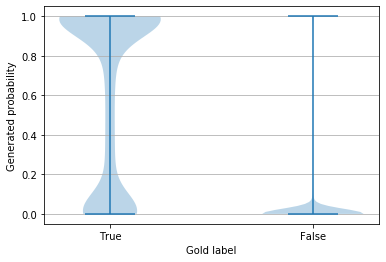

In [95]:
true_results = list(pd.to_numeric(sent_df.query("gold_label==True").loc[:,"fuzzy_result"], errors="coerce").dropna())
false_results = list(pd.to_numeric(sent_df.query("gold_label==False").loc[:,"fuzzy_result"], errors="coerce").dropna())

data = [true_results, false_results]
fig, ax = plt.subplots()
ax.violinplot(data)
ax.yaxis.grid(True)
ax.set_xticks([y + 1 for y in range(len(data))])
ax.set_xlabel("Gold label")
ax.set_ylabel("Generated probability")

plt.setp(ax, xticks=[y + 1 for y in range(len(data))], xticklabels=["True", "False"])

plt.savefig("./images/final_fuzzy_violin.png", format="png", bbox_inches="tight")
plt.show()